In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections import Counter
import glob
import heapq
import json
import numpy
import os
import pickle
import pandas as pd
import random
from tqdm import tqdm
import tensorflow as tf
import uuid

# %pylab inline
import matplotlib.pyplot as plt
from PIL import Image

import sys
sys.path.insert(0, "/recsys_data/RecSys/fashion/automl/efficientnetv2")
import effnetv2_model

from data_process import OutfitGen, OutfitGenWithImage

In [3]:
import argparse
import numpy as np
import tempfile
import shutil

import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable

from pytorchyolo.models import load_model
from pytorchyolo.utils.utils import load_classes, rescale_boxes, non_max_suppression, print_environment_info
from pytorchyolo.utils.datasets import ImageFolder
from pytorchyolo.utils.transforms import Resize, DEFAULT_TRANSFORMS

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.ticker import NullLocator


In [4]:
import anvil.server
import anvil.media
import anvil.mpl_util

anvil.server.connect("D3BJ3YVOSVMXFCEVTGLVI3XH-5GA6BUC4BEGN43RS")

Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default environment" as SERVER


In [5]:
base_dir = "/recsys_data/RecSys/fashion/polyvore-dataset/polyvore_outfits"
data_type = "disjoint" # "nondisjoint"
train_dir = os.path.join(base_dir, data_type)
image_dir = os.path.join(base_dir, "images")
embed_dir = "/recsys_data/RecSys/fashion/polyvore-dataset/precomputed"
model_name = "efficientnet"
checkpoint_filepath = base_dir + "/checkpoint"
image_embedding_file = os.path.join(embed_dir, "effnet_tuned_polyvore.pkl")
data_type = "nondisjoint"
model_type = "rnn"
max_seq_len = 8
item_file = "polyvore_item_metadata.json"

In [6]:
def detect(model, dataloader, output_path, conf_thres, nms_thres):
    """Inferences images with model.

    :param model: Model for inference
    :type model: models.Darknet
    :param dataloader: Dataloader provides the batches of images to inference
    :type dataloader: DataLoader
    :param output_path: Path to output directory
    :type output_path: str
    :param conf_thres: Object confidence threshold, defaults to 0.5
    :type conf_thres: float, optional
    :param nms_thres: IOU threshold for non-maximum suppression, defaults to 0.5
    :type nms_thres: float, optional
    :return: List of detections. The coordinates are given for the padded image that is provided by the dataloader.
        Use `utils.rescale_boxes` to transform them into the desired input image coordinate system before its transformed by the dataloader),
        List of input image paths
    :rtype: [Tensor], [str]
    """
    # Create output directory, if missing
    os.makedirs(output_path, exist_ok=True)

    model.eval()  # Set model to evaluation mode

    Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

    img_detections = []  # Stores detections for each image index
    imgs = []  # Stores image paths

    for (img_paths, input_imgs) in tqdm(dataloader, desc="Detecting"):
        # Configure input
        input_imgs = Variable(input_imgs.type(Tensor))

        # Get detections
        with torch.no_grad():
            detections = model(input_imgs)
            print(detections.shape)
            detections = non_max_suppression(detections, conf_thres, nms_thres)
            print(detections)
        # Store image and detections
        img_detections.extend(detections)
        imgs.extend(img_paths)
    return img_detections, imgs


def _draw_and_save_output_images(img_detections, imgs, img_size, output_path, classes):
    """Draws detections in output images and stores them.

    :param img_detections: List of detections
    :type img_detections: [Tensor]
    :param imgs: List of paths to image files
    :type imgs: [str]
    :param img_size: Size of each image dimension for yolo
    :type img_size: int
    :param output_path: Path of output directory
    :type output_path: str
    :param classes: List of class names
    :type classes: [str]
    """

    # Iterate through images and save plot of detections
    outpaths, detcns = [], []
    for (image_path, detections) in zip(imgs, img_detections):
        print(f"Image {image_path}:")
        op, dtcn = _draw_and_save_output_image(
            image_path, detections, img_size, output_path, classes)
        outpaths.append(op)
        detcns.append(dtcn)
    return outpaths, detcns


def _draw_and_save_output_image(image_path, detections, img_size, output_path, classes):
    """Draws detections in output image and stores this.

    :param image_path: Path to input image
    :type image_path: str
    :param detections: List of detections on image
    :type detections: [Tensor]
    :param img_size: Size of each image dimension for yolo
    :type img_size: int
    :param output_path: Path of output directory
    :type output_path: str
    :param classes: List of class names
    :type classes: [str]
    """
    # Create plot
    img = np.array(Image.open(image_path))
    plt.figure()
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    # Rescale boxes to original image
    detections = rescale_boxes(detections, img_size, img.shape[:2])
    unique_labels = detections[:, -1].cpu().unique()
    n_cls_preds = len(unique_labels)

    # Bounding-box colors
    cmap = plt.get_cmap("tab20b")
    colors = [cmap(i) for i in np.linspace(0, 1, n_cls_preds)]
    bbox_colors = random.sample(colors, n_cls_preds)
    for x1, y1, x2, y2, conf, cls_pred in detections:

        print(f"\t+ Label: {classes[int(cls_pred)]} | Confidence: {conf.item():0.4f}")
        print(x1, y1, x2, y2)

        box_w = x2 - x1
        box_h = y2 - y1

        color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
        # Create a Rectangle patch
        bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor="none")
        # Add the bbox to the plot
        ax.add_patch(bbox)
        # Add label
        plt.text(
            x1,
            y1,
            s=classes[int(cls_pred)],
            color="white",
            verticalalignment="top",
            bbox={"color": color, "pad": 0})

    # Save generated image with detections
    plt.axis("off")
    plt.gca().xaxis.set_major_locator(NullLocator())
    plt.gca().yaxis.set_major_locator(NullLocator())
    
    filename = os.path.basename(image_path).split(".")[0]
    output_path = os.path.join(output_path, f"{filename}.png")
    
    plt.savefig(output_path, bbox_inches="tight", pad_inches=0.0)
    plt.close()
    return output_path, detections

def _create_data_loader(img_path, batch_size, img_size, n_cpu):
    """Creates a DataLoader for inferencing.

    :param img_path: Path to file containing all paths to validation images.
    :type img_path: str
    :param batch_size: Size of each image batch
    :type batch_size: int
    :param img_size: Size of each image dimension for yolo
    :type img_size: int
    :param n_cpu: Number of cpu threads to use during batch generation
    :type n_cpu: int
    :return: Returns DataLoader
    :rtype: DataLoader
    """
    dataset = ImageFolder(
        img_path,
        transform=transforms.Compose([DEFAULT_TRANSFORMS, Resize(img_size)]))
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=n_cpu,
        pin_memory=True)
    return dataloader


In [7]:
# ModaNet
model_cfg = "/recsys_data/RecSys/fashion/Clothing-Detection/yolo/modanetcfg/yolov3-modanet.cfg"
model_wts = "/recsys_data/RecSys/fashion/Clothing-Detection/yolo/weights/fashion_models/yolov3-modanet_last.weights"
class_names = "/recsys_data/RecSys/fashion/Clothing-Detection/yolo/modanetcfg/modanet.names"

# DeepFashion-2
# model_cfg = "/recsys_data/RecSys/PyTorch-YOLOv3/config/yolov3-custom.cfg"
# model_wts = "/recsys_data/RecSys/PyTorch-YOLOv3/checkpoints/yolov3_ckpt_2.pth"
# class_names = "/recsys_data/RecSys/PyTorch-YOLOv3/data/custom/classes.names"

img_size = 416

classes = load_classes(class_names)
model = load_model(model_cfg, model_wts)

In [8]:
eff2_model = tf.keras.models.Sequential(
                [
                    tf.keras.layers.InputLayer(input_shape=[224, 224, 3]),
                    effnetv2_model.get_model("efficientnetv2-b0", include_top=False),
                ]
            )

Instructions for updating:
Restoring a name-based tf.train.Saver checkpoint using the object-based restore API. This mode uses global names to match variables, and so is somewhat fragile. It also adds new restore ops to the graph each time it is called when graph building. Prefer re-encoding training checkpoints in the object-based format: run save() on the object-based saver (the same one this message is coming from) and use that checkpoint in the future.


Instructions for updating:
Restoring a name-based tf.train.Saver checkpoint using the object-based restore API. This mode uses global names to match variables, and so is somewhat fragile. It also adds new restore ops to the graph each time it is called when graph building. Prefer re-encoding training checkpoints in the object-based format: run save() on the object-based saver (the same one this message is coming from) and use that checkpoint in the future.


In [9]:
def get_similar_products_from_array(image_arr, categories=None):
    """
    Search for similar items only in these categories
    """
    if categories is not None:
        search_products = set()
        for cat in categories:
            search_products |= set(cat2items[cat])
    else:
        search_products = image_embedding_dict.keys()
        
    image_arr = tf.image.resize_with_pad(image_arr, target_height=224, target_width=224).numpy()
    image_arr /= 255.0
    image_embed = tf.squeeze(eff2_model(tf.expand_dims(image_arr, 0)))

    q_vec = image_embed #.numpy()
    image_dist = []
    count = 0
    for image in tqdm(search_products):
        i_vec = image_embedding_dict[image]
        dist = numpy.linalg.norm(q_vec - i_vec.numpy())
        heapq.heappush(image_dist, (dist, image))
        count += 1

    top_images = [heapq.heappop(image_dist) for _ in range(5)]
#     top_images = [item for s, item in top_images]
#     top_images = [os.path.join(image_dir, item + ".jpg") for s, item in top_images]
#     top_images = [ anvil.media.from_file(os.path.join(image_dir, item + ".jpg"), 'image/jpeg') for s, item in top_images]
    return top_images
    

In [10]:
with open(image_embedding_file, "rb") as fr:
    image_embedding_dict = pickle.load(fr)
print(f"Loaded {len(image_embedding_dict)} image embeddings")

Loaded 261057 image embeddings


In [11]:
modanet2polyvore = {'bag': 'bags',
                    'belt': 'accessories',
                    'boots': 'shoes',
                    'footwear': 'shoes',
                    'outer': 'outerwear',
                    'dress': 'all-body',
                    'sunglasses': 'sunglasses',
                    'pants': 'bottoms',
                    'top': 'tops',
                    'shorts': 'bottoms',
                    'skirt': 'bottoms',
                    'headwear': 'hats',
                    'scarf/tie': 'scarves',
                   }

In [12]:
with open(os.path.join(base_dir, item_file), 'r') as fr:
    pv_items = json.load(fr)

In [13]:
id2cat = dict()
cat2items = dict()  # seggregate items by category
all_scats = list()
for item in pv_items:
    iid, cat = pv_items[item]["category_id"], pv_items[item]["semantic_category"]
    if iid not in id2cat:
        id2cat[iid] = cat
    if cat not in cat2items:
        cat2items[cat] = []
    cat2items[cat].append(item)
    all_scats.append(cat)

## Shop The Look

In [14]:
@anvil.server.callable
def get_fashion_objects(file):
    """
    dependencies:
        get_similar_products_from_array()
        modanet2polyvore dict
        eff2_model
    """
    img_size = 416
    temp_dir = tempfile.TemporaryDirectory()
    output_path = tempfile.TemporaryDirectory()
    img_path = temp_dir.name+"/test.jpg"
    with anvil.media.TempFile(file) as filename:
        shutil.copyfile(filename, img_path)

    dataloader = _create_data_loader(temp_dir.name, batch_size=1, img_size=416, n_cpu=6)
    img_detections, imgs = detect(
        model,
        dataloader,
        output_path.name,
        conf_thres=0.5,
        nms_thres=0.4)

    filepaths, details = _draw_and_save_output_images(
        img_detections, imgs, img_size, output_path.name, classes)
    
    res = {'original': []}
    for filepath in filepaths:
        res['original'].append(anvil.media.from_file(filepath, 'image/png'))
    
    # original file
    im = np.array(Image.open(img_path))
    for x1, y1, x2, y2, conf, cls_pred in details[0]:
        pred_class = classes[int(cls_pred)]
        if pred_class in ("outer", "dress", "pants", "top", "shorts", "skirt"):
            res[pred_class] = []
            A = im[int(y1):int(y2), int(x1):int(x2), :]
            im2 = Image.fromarray(A)
            bfile = temp_dir.name+f"/{pred_class}.png"
            im2.save(bfile)
            res[pred_class].append(anvil.media.from_file(bfile, 'image/png'))
            similar_prods = get_similar_products_from_array(image_arr=A, 
                                                            categories=[modanet2polyvore[pred_class]])
            top_prods = [anvil.media.from_file(os.path.join(image_dir, item + ".jpg"), 'image/jpeg') for s, item in similar_prods]
            res[pred_class].extend(top_prods)

    temp_dir.cleanup()
    output_path.cleanup()

    return res


Detecting: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

torch.Size([1, 10647, 18])
1. torch.Size([1, 10647, 18])
tensor([2.5547e-06, 3.7309e-07, 8.5172e-08,  ..., 5.2484e-07, 8.1012e-07,
        2.0310e-07], device='cuda:0')
tensor([[2.0810e+02, 1.7854e+02, 1.2104e+02, 1.3161e+02, 9.3810e-01, 2.0395e-04,
         1.1309e-04, 1.2562e-03, 3.7108e-04, 7.2259e-01, 3.0515e-03, 2.1285e-04,
         3.7554e-04, 4.7890e-01, 8.2428e-05, 1.6749e-04, 2.5712e-04, 4.1306e-03],
        [2.0822e+02, 1.7637e+02, 1.4077e+02, 1.3945e+02, 9.4842e-01, 1.1454e-04,
         1.9932e-04, 6.6779e-04, 6.2007e-04, 6.9677e-01, 1.9304e-03, 3.2148e-04,
         4.0872e-04, 3.8150e-01, 1.9441e-04, 1.7352e-04, 5.1675e-04, 2.1071e-03],
        [2.1816e+02, 3.9541e+02, 3.0450e+01, 3.9596e+01, 7.2003e-01, 6.0526e-04,
         2.7689e-04, 3.9740e-02, 9.7468e-01, 2.5810e-04, 2.6188e-04, 6.5437e-04,
         4.7658e-04, 1.1833e-03, 5.9381e-04, 5.8722e-04, 8.5028e-04, 2.8252e-04],
        [2.0217e+02, 2.9962e+02, 8.2297e+01, 1.5533e+02, 5.6490e-01, 4.8503e-04,
         3.4381e-0


Detecting: 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]

torch.Size([1, 10647, 18])
1. torch.Size([1, 10647, 18])
tensor([6.6539e-07, 1.8017e-08, 4.4419e-09,  ..., 5.3866e-07, 9.2579e-07,
        2.3520e-07], device='cuda:0')
tensor([[1.8880e+02, 1.7368e+02, 1.0212e+02, 1.3099e+02, 8.1193e-01, 5.7933e-05,
         2.8962e-04, 1.1825e-04, 4.4831e-05, 9.7788e-01, 2.2069e-04, 1.4080e-05,
         1.3226e-04, 1.7257e-02, 2.9803e-05, 1.0692e-05, 9.4410e-05, 2.0354e-03],
        [1.9583e+02, 1.7512e+02, 1.0831e+02, 1.3259e+02, 9.4574e-01, 2.4659e-05,
         1.3253e-04, 1.0667e-04, 1.5460e-05, 9.9133e-01, 7.5997e-05, 6.0108e-06,
         9.5344e-05, 1.1470e-02, 1.5968e-05, 6.8991e-06, 7.9785e-05, 1.8702e-04],
        [2.0247e+02, 2.7683e+02, 8.7772e+01, 1.7090e+02, 9.0772e-01, 5.4879e-03,
         1.2323e-04, 2.2998e-05, 2.8631e-04, 2.8888e-03, 2.1845e-05, 1.2922e-04,
         9.8886e-01, 9.3956e-06, 1.7388e-04, 1.8399e-05, 2.7772e-05, 2.1915e-05],
        [1.8630e+02, 1.6525e+02, 2.1498e+01, 5.7584e+01, 6.4186e-01, 5.8460e-05,
         2.2660e-0

Detecting: 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


Image /tmp/tmp9i2xyauo/test.jpg:
	+ Label: sunglasses | Confidence: 0.9795
tensor(554.0140) tensor(377.6691) tensor(733.8295) tensor(441.6472)
	+ Label: outer | Confidence: 0.9375
tensor(349.3960) tensor(523.2247) tensor(870.1401) tensor(1160.6635)
	+ Label: pants | Confidence: 0.8976
tensor(430.7049) tensor(920.1126) tensor(852.6834) tensor(1741.7277)
	+ Label: footwear | Confidence: 0.8309
tensor(547.9059) tensor(1703.4592) tensor(648.5969) tensor(1941.9825)
	+ Label: bag | Confidence: 0.7874
tensor(349.8491) tensor(1165.6492) tensor(570.5358) tensor(1634.1432)
	+ Label: top | Confidence: 0.6400
tensor(512.2802) tensor(656.0298) tensor(615.6353) tensor(932.8763)


100%|██████████| 32998/32998 [00:14<00:00, 2301.71it/s]


## Load the Outfit Compatibility Model

In [15]:
from focal_loss import BinaryFocalLoss

compatibility_model = tf.keras.models.load_model('compatibility_nondisjoint_single-transformer_model_8_only_image')
compatibility_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 8, 1280)]         0         
_________________________________________________________________
dense_39 (Dense)             (None, 8, 64)             81984     
_________________________________________________________________
encoder_1 (Encoder)          (None, 8, 64)             130048    
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               328704    
_________________________________________________________________
dense_77 (Dense)             (None, 1)                 257       
Total params: 540,993
Trainable params: 540,993
Non-trainable params: 0
_________________________________________________________________


In [39]:
def return_top_items(query_item, model, image_embedding_dict, item_dict, ignore=None, search_only=None, max_item=8):
    if type(query_item) is not list:
        query_item = [query_item]
    data_gen = OutfitGenWithImage(embed_dir=embed_dir,
                                  text_embed_file="bert_polyvore.pkl",
                                  batch_size=256,
                                  max_len=max_item,
                                  image_embedding_dim=1280,
                                  query_item=query_item,
                                  image_embedding_dict=image_embedding_dict,
                                  item_description=item_dict,
                                  item_category_dict=cat2items,
                                  # ignore_categories=ignore,
                                  search_only_categories=search_only,
                                 )
    pbar = tqdm(range(len(data_gen)))
    current_score = []
    # adds one more item to the list of current items (stored in query_item)
    for ii in pbar:
        x, items = data_gen[ii]
        yhat = model(x)
        for cs, item in zip(yhat, items):
            heapq.heappush(current_score, (1-cs, query_item + [str(item)]))  # it's a min-heap
    return current_score

def filter_outfits(outfits, item_dict, max_len):
    # retain only those combinations where all categories are distinct
    count = 0
    filtered = []
    while count < max_len: 
        outfit = heapq.heappop(outfits)
        items = outfit[1]
        categories = [item_dict[item]['semantic_category'] for item in items]
        if len(set(categories)) == len(categories):
            filtered.append(items)
            count += 1
    return filtered

def get_next_category(cats, global_categories):
    # returns the next category to search from
    for cat in global_categories:
        if cat not in cats:
            return cat
    return None

def create_outfit(query, category, model, image_dict, item_dict, max_item=8, beam_length=2):
    """
        query: image embedding or polyvore item-id
        catgeory: category of the image, str
        model: compatibility model (pretrained)
        image_dict: image to embedding dict
        item_dict: item to item details dict
        max_item: maximum number of items in the outfit
        beam_length: number of alternative outfits
    """
    ## TODO: modify for multiple image inputs 
    
    # create new item-id and update embedding_dict and category_dict
    if type(query) is not str:
        item_id = str(uuid.uuid4())
        image_dict[item_id] = query
        item_dict[item_id] = {}
        item_dict[item_id]['semantic_category'] = category
    else:
        item_id = query
    
    # Based on the global category distribution find the next category to search from
    top_level_category_order = ['shoes', 'jewellery', 'bags', 'tops', 'bottoms',
                      'all-body', 'outerwear', 'sunglasses', 'accessories', 'hats', 'scarves']
    next_category = get_next_category([category], top_level_category_order)

    # add the first item - only one run
    first_score = return_top_items(item_id,
                                   model,
                                   image_dict, 
                                   item_dict, 
                                   ignore=[category], 
                                   search_only=[next_category])
    current_items = filter_outfits(first_score, item_dict, beam_length)
    
    for jj in range(1, max_item):
        all_scores = []
        for ii in range(beam_length):
            ignore_categories = [item_dict[item]['semantic_category'] for item in current_items[ii]]
            next_category = get_next_category(ignore_categories, top_level_category_order)
            scores_ii = return_top_items(current_items[ii],
                                         model,
                                         image_dict, 
                                         item_dict, 
                                         ignore_categories,
                                         search_only=[next_category],
                                        )
            all_scores += scores_ii
        # reconstruct current items - with one new item
        current_items = filter_outfits(all_scores, item_dict, beam_length)
    
    return current_items

def get_complementary_products_from_array(image_arr, image_cat, max_item=4):
    """
    Search for complementary items using Compatibility model
    """
    image_arr = tf.image.resize_with_pad(image_arr, target_height=224, target_width=224).numpy()
    image_arr /= 255.0
    image_embed = tf.squeeze(eff2_model(tf.expand_dims(image_arr, 0)))

    outfits = create_outfit(query=image_embed,
                            category=image_cat,
                            model=compatibility_model,
                            image_dict=image_embedding_dict.copy(), 
                            item_dict=pv_items.copy(), 
                            max_item=int(max_item), 
                            beam_length=1)
    # since beam_length is fixed at 1, we take the first element
    # also the first element in the list is the original item that
    # we don't have to return
    return outfits[0][1:]


Detecting: 100%|██████████| 1/1 [00:01<00:00,  1.22s/it]

torch.Size([1, 10647, 18])
1. torch.Size([1, 10647, 18])
tensor([6.6539e-07, 1.8017e-08, 4.4419e-09,  ..., 5.3866e-07, 9.2579e-07,
        2.3520e-07], device='cuda:0')
tensor([[1.8880e+02, 1.7368e+02, 1.0212e+02, 1.3099e+02, 8.1193e-01, 5.7933e-05,
         2.8962e-04, 1.1825e-04, 4.4831e-05, 9.7788e-01, 2.2069e-04, 1.4080e-05,
         1.3226e-04, 1.7257e-02, 2.9803e-05, 1.0692e-05, 9.4410e-05, 2.0354e-03],
        [1.9583e+02, 1.7512e+02, 1.0831e+02, 1.3259e+02, 9.4574e-01, 2.4659e-05,
         1.3253e-04, 1.0667e-04, 1.5460e-05, 9.9133e-01, 7.5997e-05, 6.0108e-06,
         9.5344e-05, 1.1470e-02, 1.5968e-05, 6.8991e-06, 7.9785e-05, 1.8702e-04],
        [2.0247e+02, 2.7683e+02, 8.7772e+01, 1.7090e+02, 9.0772e-01, 5.4879e-03,
         1.2323e-04, 2.2998e-05, 2.8631e-04, 2.8888e-03, 2.1845e-05, 1.2922e-04,
         9.8886e-01, 9.3956e-06, 1.7388e-04, 1.8399e-05, 2.7772e-05, 2.1915e-05],
        [1.8630e+02, 1.6525e+02, 2.1498e+01, 5.7584e+01, 6.4186e-01, 5.8460e-05,
         2.2660e-0

	+ Label: sunglasses | Confidence: 0.9795
tensor(554.0140) tensor(377.6691) tensor(733.8295) tensor(441.6472)
	+ Label: outer | Confidence: 0.9375
tensor(349.3960) tensor(523.2247) tensor(870.1401) tensor(1160.6635)
	+ Label: pants | Confidence: 0.8976
tensor(430.7049) tensor(920.1126) tensor(852.6834) tensor(1741.7277)
	+ Label: footwear | Confidence: 0.8309
tensor(547.9059) tensor(1703.4592) tensor(648.5969) tensor(1941.9825)
	+ Label: bag | Confidence: 0.7874
tensor(349.8491) tensor(1165.6492) tensor(570.5358) tensor(1634.1432)
	+ Label: top | Confidence: 0.6400
tensor(512.2802) tensor(656.0298) tensor(615.6353) tensor(932.8763)
Searching limited to ['shoes']
Original 261058 items, reduced to 44850 items


100%|██████████| 176/176 [01:01<00:00,  2.87it/s]


Searching limited to ['jewellery']
Original 261058 items, reduced to 41414 items


100%|██████████| 162/162 [00:56<00:00,  2.87it/s]


Searching limited to ['bags']
Original 261058 items, reduced to 40717 items


100%|██████████| 160/160 [00:56<00:00,  2.83it/s]


Searching limited to ['tops']
Original 261058 items, reduced to 32998 items


100%|██████████| 129/129 [00:46<00:00,  2.75it/s]


['169711051', '201263438', '102371068', '148015594']
Searching limited to ['shoes']
Original 261058 items, reduced to 44850 items


100%|██████████| 176/176 [01:01<00:00,  2.84it/s]


Searching limited to ['jewellery']
Original 261058 items, reduced to 41414 items


100%|██████████| 162/162 [00:56<00:00,  2.84it/s]


Searching limited to ['bags']
Original 261058 items, reduced to 40717 items


100%|██████████| 160/160 [00:56<00:00,  2.85it/s]


Searching limited to ['tops']
Original 261058 items, reduced to 32998 items


100%|██████████| 129/129 [00:46<00:00,  2.79it/s]


['205926729', '213083210', '209600134', '195697696']
Searching limited to ['shoes']
Original 261058 items, reduced to 44850 items


100%|██████████| 176/176 [01:02<00:00,  2.84it/s]


Searching limited to ['jewellery']
Original 261058 items, reduced to 41414 items


100%|██████████| 162/162 [00:57<00:00,  2.83it/s]


Searching limited to ['bags']
Original 261058 items, reduced to 40717 items


100%|██████████| 160/160 [00:56<00:00,  2.85it/s]


Searching limited to ['bottoms']
Original 261058 items, reduced to 27670 items


100%|██████████| 109/109 [00:39<00:00,  2.79it/s]


['169711051', '204550975', '83815726', '213935207']


## Complete The Look

In [27]:
@anvil.server.callable
def complete_the_look(file):
    """
    dependencies:
        get_similar_products_from_array()
        modanet2polyvore dict
        eff2_model
        compatibility model
    """
    img_size = 416
    temp_dir = tempfile.TemporaryDirectory()
    output_path = tempfile.TemporaryDirectory()
    img_path = temp_dir.name+"/test.jpg"
    with anvil.media.TempFile(file) as filename:
        shutil.copyfile(filename, img_path)

    dataloader = _create_data_loader(temp_dir.name, batch_size=1, img_size=416, n_cpu=6)
    img_detections, imgs = detect(
        model,
        dataloader,
        output_path.name,
        conf_thres=0.5,
        nms_thres=0.4)

    filepaths, details = _draw_and_save_output_images(
        img_detections, imgs, img_size, output_path.name, classes)
    
    res = {'original': []}
    for filepath in filepaths:
        res['original'].append(anvil.media.from_file(filepath, 'image/png'))
    
    # original file
    im = np.array(Image.open(img_path))
    for x1, y1, x2, y2, conf, cls_pred in details[0]:
        pred_class = classes[int(cls_pred)]
        if pred_class in ("outer", "dress", "pants", "top", "shorts", "skirt"):
            res[pred_class] = []
            A = im[int(y1):int(y2), int(x1):int(x2), :]
            im2 = Image.fromarray(A)
            bfile = temp_dir.name+f"/{pred_class}.png"
            im2.save(bfile)
            res[pred_class].append(anvil.media.from_file(bfile, 'image/png'))
            complementary_prods = get_complementary_products_from_array(image_arr=A, 
                                                            image_cat=modanet2polyvore[pred_class])
            print(complementary_prods)
            top_prods = [anvil.media.from_file(os.path.join(image_dir, item + ".jpg"), 'image/jpeg') for item in complementary_prods]
            res[pred_class].extend(top_prods)

    temp_dir.cleanup()
    output_path.cleanup()

    return res


Detecting: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

torch.Size([1, 10647, 18])
1. torch.Size([1, 10647, 18])
tensor([6.6539e-07, 1.8017e-08, 4.4419e-09,  ..., 5.3866e-07, 9.2579e-07,
        2.3520e-07], device='cuda:0')
tensor([[1.8880e+02, 1.7368e+02, 1.0212e+02, 1.3099e+02, 8.1193e-01, 5.7933e-05,
         2.8962e-04, 1.1825e-04, 4.4831e-05, 9.7788e-01, 2.2069e-04, 1.4080e-05,
         1.3226e-04, 1.7257e-02, 2.9803e-05, 1.0692e-05, 9.4410e-05, 2.0354e-03],
        [1.9583e+02, 1.7512e+02, 1.0831e+02, 1.3259e+02, 9.4574e-01, 2.4659e-05,
         1.3253e-04, 1.0667e-04, 1.5460e-05, 9.9133e-01, 7.5997e-05, 6.0108e-06,
         9.5344e-05, 1.1470e-02, 1.5968e-05, 6.8991e-06, 7.9785e-05, 1.8702e-04],
        [2.0247e+02, 2.7683e+02, 8.7772e+01, 1.7090e+02, 9.0772e-01, 5.4879e-03,
         1.2323e-04, 2.2998e-05, 2.8631e-04, 2.8888e-03, 2.1845e-05, 1.2922e-04,
         9.8886e-01, 9.3956e-06, 1.7388e-04, 1.8399e-05, 2.7772e-05, 2.1915e-05],
        [1.8630e+02, 1.6525e+02, 2.1498e+01, 5.7584e+01, 6.4186e-01, 5.8460e-05,
         2.2660e-0

Detecting: 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Image /tmp/tmpmcfonemc/test.jpg:
	+ Label: sunglasses | Confidence: 0.9795
tensor(554.0140) tensor(377.6691) tensor(733.8295) tensor(441.6472)
	+ Label: outer | Confidence: 0.9375
tensor(349.3960) tensor(523.2247) tensor(870.1401) tensor(1160.6635)
	+ Label: pants | Confidence: 0.8976
tensor(430.7049) tensor(920.1126) tensor(852.6834) tensor(1741.7277)
	+ Label: footwear | Confidence: 0.8309
tensor(547.9059) tensor(1703.4592) tensor(648.5969) tensor(1941.9825)
	+ Label: bag | Confidence: 0.7874
tensor(349.8491) tensor(1165.6492) tensor(570.5358) tensor(1634.1432)
	+ Label: top | Confidence: 0.6400
tensor(512.2802) tensor(656.0298) tensor(615.6353) tensor(932.8763)
Searching limited to ['shoes']
Original 261058 items, reduced to 44850 items


100%|██████████| 176/176 [01:00<00:00,  2.92it/s]


[['8cd42966-2e18-4491-9101-d9f16f3116c5', '169711051']]
Searching limited to ['jewellery']
Original 261058 items, reduced to 41414 items


100%|██████████| 162/162 [00:55<00:00,  2.91it/s]


['169711051', '201263438']
Searching limited to ['shoes']
Original 261058 items, reduced to 44850 items


100%|██████████| 176/176 [01:00<00:00,  2.89it/s]


[['39f3d157-f71f-4da0-92a3-8c39f7e3c52b', '205926729']]
Searching limited to ['jewellery']
Original 261058 items, reduced to 41414 items


100%|██████████| 162/162 [00:55<00:00,  2.92it/s]


['205926729', '213083210']
Searching limited to ['shoes']
Original 261058 items, reduced to 44850 items


100%|██████████| 176/176 [01:01<00:00,  2.87it/s]


[['d09f6b5c-200c-4784-a548-ce1d6d9fae9e', '169711051']]
Searching limited to ['jewellery']
Original 261058 items, reduced to 41414 items


100%|██████████| 162/162 [00:55<00:00,  2.94it/s]


['169711051', '204550975']


## Outfit Generation

In [29]:
category_model = tf.keras.models.load_model(f"finetuned_efficientnet")

In [30]:
import pandas as pd

# original logic of creating the labels
# taken from ImageDataGen()
X, y = [], []
for item_id in pv_items:
    X.append(item_id)
    y.append(pv_items[item_id]["category_id"])

X_col = "X"
y_col = "y"
df = pd.DataFrame({X_col: X, y_col: y})
categories = df[y_col].unique()
label_dict = {ii: jj for ii, jj in enumerate(categories)} # reversing

In [31]:
def get_product_category(query):
    image = tf.keras.preprocessing.image.load_img(query)
    image_arr = tf.keras.preprocessing.image.img_to_array(image)
    # image_arr = tf.image.resize(image_arr, (224, 224)).numpy()
    image_arr = tf.image.resize_with_pad(image_arr, target_height=224, target_width=224).numpy()
    image_arr /= 255.0
    pred_score = category_model(tf.expand_dims(image_arr, 0))
    pred_label = np.argmax(pred_score, axis=1)[0]
    pred_label = label_dict[pred_label]  # class number as given in the item description
    return pred_label, id2cat[pred_label]

def get_product_category_2(image_arr):
    pred_score = category_model(tf.expand_dims(image_arr, 0))
    pred_label = np.argmax(pred_score, axis=1)[0]  # index of the class
    pred_label = label_dict[pred_label]  # class number as given in the item description
    return pred_label, id2cat[pred_label]


19 tops
Searching limited to ['shoes']
Original 261058 items, reduced to 44850 items


100%|██████████| 176/176 [00:56<00:00,  3.09it/s]


[['922363f8-7bf7-4671-b6ee-49c5edd4ca2d', '190305861'], ['922363f8-7bf7-4671-b6ee-49c5edd4ca2d', '162729207']]
Searching limited to ['jewellery']
Original 261058 items, reduced to 41414 items


100%|██████████| 162/162 [00:52<00:00,  3.10it/s]


Searching limited to ['jewellery']
Original 261058 items, reduced to 41414 items


100%|██████████| 162/162 [00:53<00:00,  3.04it/s]


[['922363f8-7bf7-4671-b6ee-49c5edd4ca2d', '190305861', '6204449'], ['922363f8-7bf7-4671-b6ee-49c5edd4ca2d', '190305861', '110260636']]


In [28]:
@anvil.server.callable
def get_outfit(file, max_item=3):
    with anvil.media.TempFile(file) as filename:
        image = tf.keras.preprocessing.image.load_img(filename)

    image_arr = tf.keras.preprocessing.image.img_to_array(image)
    # image_arr = tf.image.resize(image_arr, (224, 224)).numpy()
    image_arr = tf.image.resize_with_pad(image_arr, target_height=224, target_width=224).numpy()
    image_arr /= 255.0
    image_embed = tf.squeeze(eff2_model(tf.expand_dims(image_arr, 0)))
    image_cat_id, image_cat = get_product_category_2(image_arr)
    print(image_cat_id, image_cat)
    outfits = create_outfit(query=image_embed,
                            category=image_cat,
                            model=compatibility_model,
                            image_dict=image_embedding_dict.copy(), 
                            item_dict=pv_items.copy(), 
                            max_item=int(max_item), 
                            beam_length=2)
    print(outfits)
    outfit_images = []
    for prods in outfits:
        res = []
        for item in prods[1:]:
            filepath = os.path.join(image_dir, item + ".jpg")
            res.append(anvil.media.from_file(filepath, 'image/jpeg'))
        outfit_images.append(res)
    return outfit_images


## Search Similar Products

In [32]:
@anvil.server.callable
def get_similar_products(file):
    with anvil.media.TempFile(file) as filename:
        image = tf.keras.preprocessing.image.load_img(filename)

    image_arr = tf.keras.preprocessing.image.img_to_array(image)
    # image_arr = tf.image.resize(image_arr, (224, 224)).numpy()
    image_arr = tf.image.resize_with_pad(image_arr, target_height=224, target_width=224).numpy()
    image_arr /= 255.0
    cid, cat = get_product_category_2(image_arr)
    search_products = cat2items[cat]
    print(f"Searching in {cat} category, {len(search_products)} products")
    
    image_embed = tf.squeeze(eff2_model(tf.expand_dims(image_arr, 0)))
    q_vec = image_embed #.numpy()
    image_dist = []
    count = 0
    for image in tqdm(search_products):
        i_vec = image_embedding_dict[image]
#     for image, i_vec in tqdm(image_embedding_dict.items()):
        dist = numpy.linalg.norm(q_vec - i_vec.numpy())
        heapq.heappush(image_dist, (dist, image))
        count += 1

    top_images = [heapq.heappop(image_dist) for _ in range(5)]
    top_images = [ anvil.media.from_file(os.path.join(image_dir, item + ".jpg"), 'image/jpeg') for s, item in top_images]
    return top_images


Searching in tops category, 32998 products


100%|██████████| 32998/32998 [00:13<00:00, 2438.47it/s]


19 tops
Searching limited to ['shoes']
Original 261058 items, reduced to 44850 items


100%|██████████| 176/176 [00:56<00:00,  3.09it/s]


[['f36eb2de-746e-4bc0-b77f-002e7acb3056', '190305861'], ['f36eb2de-746e-4bc0-b77f-002e7acb3056', '162729207']]
Searching limited to ['jewellery']
Original 261058 items, reduced to 41414 items


100%|██████████| 162/162 [00:52<00:00,  3.07it/s]


Searching limited to ['jewellery']
Original 261058 items, reduced to 41414 items


100%|██████████| 162/162 [00:52<00:00,  3.11it/s]


[['f36eb2de-746e-4bc0-b77f-002e7acb3056', '190305861', '6204449'], ['f36eb2de-746e-4bc0-b77f-002e7acb3056', '190305861', '110260636']]


## Outfit Compatibility Score

In [35]:
@anvil.server.callable
def get_compatibility_score(files):
    size = 224, 224
    embed_dim = 1280
    max_len = 8
    outfit_embeddings = []
    count = 0
    zero_elem_image = np.zeros(embed_dim)
    for file in files:
        with anvil.media.TempFile(file) as filename:
            image = tf.keras.preprocessing.image.load_img(filename)
            image_arr = tf.keras.preprocessing.image.img_to_array(image)
            w, h, c = image_arr.shape
            aspect = h*1.0/w
            if aspect > 1.5:
                image_arr = tf.image.resize_with_pad(image_arr, target_height=224, target_width=224).numpy()
            else:
                image_arr = tf.image.resize(image_arr, size).numpy()
            image_arr /= 255.0
            image_embed = tf.squeeze(eff2_model(tf.expand_dims(image_arr, 0)))
            outfit_embeddings.append(image_embed)
            count += 1

    zeros_image = [zero_elem_image for _ in range(max_len - count)]
    outfit_embeddings = np.stack(zeros_image + outfit_embeddings)
    outfit_embeddings = np.expand_dims(outfit_embeddings, 0)
    score = compatibility_model(outfit_embeddings).numpy()[0][0]
    return score

In [38]:
def create_outfit_2(query, category, required, model, image_dict, item_dict, beam_length=10):
    # query is always a list of images
    # create new item-id and update embedding_dict and category_dict
    # get only one item
    items = []
    for item, cat in zip(query, category):
        item_id = str(uuid.uuid4())
        image_dict[item_id] = item
        item_dict[item_id] = {}
        item_dict[item_id]['semantic_category'] = cat
        items.append(item_id)
    
    # add the first item - only one run
    if required is not None:
        print(required)
        all_cats = set(list(id2cat.values()))
        category = all_cats.difference(set(required))
        
    first_score = return_top_items(items, 
                                   model, 
                                   image_dict, 
                                   item_dict, 
                                   ignore=category,
                                   search_only=required
                                  )
    if len(category) == len(set(category)):
        # if the original outfit has duplicate categories then the following
        # function will not work
        current_items = filter_outfits(first_score, item_dict, beam_length)
    else:
        count = 0
        current_items = []
        while count < beam_length: 
            outfit = heapq.heappop(first_score)
            items = outfit[1]
            current_items.append(items)
            count += 1
        
    return current_items

['bags', 'shoes', 'jewellery']
['tops']
Searching limited to ['tops']
Original 261060 items, reduced to 32998 items


100%|██████████| 129/129 [00:43<00:00,  2.95it/s]


[['1a4ce92c-80ba-4856-9550-81bb01ff0608', '0889fc63-d012-418c-9b52-d4aafbec9115', '232dbe8a-10e6-4c1f-99ad-69d73dc35d2e', '213513387'], ['1a4ce92c-80ba-4856-9550-81bb01ff0608', '0889fc63-d012-418c-9b52-d4aafbec9115', '232dbe8a-10e6-4c1f-99ad-69d73dc35d2e', '16896631'], ['1a4ce92c-80ba-4856-9550-81bb01ff0608', '0889fc63-d012-418c-9b52-d4aafbec9115', '232dbe8a-10e6-4c1f-99ad-69d73dc35d2e', '163204948']]


Detecting: 100%|██████████| 1/1 [00:02<00:00,  2.20s/it]

torch.Size([1, 10647, 18])
1. torch.Size([1, 10647, 18])
tensor([6.6539e-07, 1.8017e-08, 4.4419e-09,  ..., 5.3866e-07, 9.2579e-07,
        2.3520e-07], device='cuda:0')
tensor([[1.8880e+02, 1.7368e+02, 1.0212e+02, 1.3099e+02, 8.1193e-01, 5.7933e-05,
         2.8962e-04, 1.1825e-04, 4.4831e-05, 9.7788e-01, 2.2069e-04, 1.4080e-05,
         1.3226e-04, 1.7257e-02, 2.9803e-05, 1.0692e-05, 9.4410e-05, 2.0354e-03],
        [1.9583e+02, 1.7512e+02, 1.0831e+02, 1.3259e+02, 9.4574e-01, 2.4659e-05,
         1.3253e-04, 1.0667e-04, 1.5460e-05, 9.9133e-01, 7.5997e-05, 6.0108e-06,
         9.5344e-05, 1.1470e-02, 1.5968e-05, 6.8991e-06, 7.9785e-05, 1.8702e-04],
        [2.0247e+02, 2.7683e+02, 8.7772e+01, 1.7090e+02, 9.0772e-01, 5.4879e-03,
         1.2323e-04, 2.2998e-05, 2.8631e-04, 2.8888e-03, 2.1845e-05, 1.2922e-04,
         9.8886e-01, 9.3956e-06, 1.7388e-04, 1.8399e-05, 2.7772e-05, 2.1915e-05],
        [1.8630e+02, 1.6525e+02, 2.1498e+01, 5.7584e+01, 6.4186e-01, 5.8460e-05,
         2.2660e-0

	+ Label: sunglasses | Confidence: 0.9795
tensor(554.0140) tensor(377.6691) tensor(733.8295) tensor(441.6472)
	+ Label: outer | Confidence: 0.9375
tensor(349.3960) tensor(523.2247) tensor(870.1401) tensor(1160.6635)
	+ Label: pants | Confidence: 0.8976
tensor(430.7049) tensor(920.1126) tensor(852.6834) tensor(1741.7277)
	+ Label: footwear | Confidence: 0.8309
tensor(547.9059) tensor(1703.4592) tensor(648.5969) tensor(1941.9825)
	+ Label: bag | Confidence: 0.7874
tensor(349.8491) tensor(1165.6492) tensor(570.5358) tensor(1634.1432)
	+ Label: top | Confidence: 0.6400
tensor(512.2802) tensor(656.0298) tensor(615.6353) tensor(932.8763)


Detecting: 100%|██████████| 1/1 [00:01<00:00,  1.39s/it]

torch.Size([1, 10647, 18])
1. torch.Size([1, 10647, 18])
tensor([6.6539e-07, 1.8017e-08, 4.4419e-09,  ..., 5.3866e-07, 9.2579e-07,
        2.3520e-07], device='cuda:0')
tensor([[1.8880e+02, 1.7368e+02, 1.0212e+02, 1.3099e+02, 8.1193e-01, 5.7933e-05,
         2.8962e-04, 1.1825e-04, 4.4831e-05, 9.7788e-01, 2.2069e-04, 1.4080e-05,
         1.3226e-04, 1.7257e-02, 2.9803e-05, 1.0692e-05, 9.4410e-05, 2.0354e-03],
        [1.9583e+02, 1.7512e+02, 1.0831e+02, 1.3259e+02, 9.4574e-01, 2.4659e-05,
         1.3253e-04, 1.0667e-04, 1.5460e-05, 9.9133e-01, 7.5997e-05, 6.0108e-06,
         9.5344e-05, 1.1470e-02, 1.5968e-05, 6.8991e-06, 7.9785e-05, 1.8702e-04],
        [2.0247e+02, 2.7683e+02, 8.7772e+01, 1.7090e+02, 9.0772e-01, 5.4879e-03,
         1.2323e-04, 2.2998e-05, 2.8631e-04, 2.8888e-03, 2.1845e-05, 1.2922e-04,
         9.8886e-01, 9.3956e-06, 1.7388e-04, 1.8399e-05, 2.7772e-05, 2.1915e-05],
        [1.8630e+02, 1.6525e+02, 2.1498e+01, 5.7584e+01, 6.4186e-01, 5.8460e-05,
         2.2660e-0

	+ Label: sunglasses | Confidence: 0.9795
tensor(554.0140) tensor(377.6691) tensor(733.8295) tensor(441.6472)
	+ Label: outer | Confidence: 0.9375
tensor(349.3960) tensor(523.2247) tensor(870.1401) tensor(1160.6635)
	+ Label: pants | Confidence: 0.8976
tensor(430.7049) tensor(920.1126) tensor(852.6834) tensor(1741.7277)
	+ Label: footwear | Confidence: 0.8309
tensor(547.9059) tensor(1703.4592) tensor(648.5969) tensor(1941.9825)
	+ Label: bag | Confidence: 0.7874
tensor(349.8491) tensor(1165.6492) tensor(570.5358) tensor(1634.1432)
	+ Label: top | Confidence: 0.6400
tensor(512.2802) tensor(656.0298) tensor(615.6353) tensor(932.8763)
Searching limited to ['shoes']
Original 261058 items, reduced to 44850 items


100%|██████████| 176/176 [01:01<00:00,  2.88it/s]


[['b16e8b27-bd2c-4280-aad6-3c77e4b337f3', '169711051']]
Searching limited to ['jewellery']
Original 261058 items, reduced to 41414 items


100%|██████████| 162/162 [00:55<00:00,  2.90it/s]


['169711051', '201263438']
Searching limited to ['shoes']
Original 261058 items, reduced to 44850 items


100%|██████████| 176/176 [01:00<00:00,  2.91it/s]


[['e792f03f-599a-46ea-97dc-1a1631c0f86f', '205926729']]
Searching limited to ['jewellery']
Original 261058 items, reduced to 41414 items


100%|██████████| 162/162 [00:55<00:00,  2.92it/s]


['205926729', '213083210']
Searching limited to ['shoes']
Original 261058 items, reduced to 44850 items


100%|██████████| 176/176 [01:01<00:00,  2.88it/s]


[['f3e363b1-a3ba-4e0f-b648-a65c4f63fe31', '169711051']]
Searching limited to ['jewellery']
Original 261058 items, reduced to 41414 items


100%|██████████| 162/162 [00:55<00:00,  2.92it/s]


['169711051', '204550975']


Detecting: 100%|██████████| 1/1 [00:01<00:00,  1.93s/it]

torch.Size([1, 10647, 18])
1. torch.Size([1, 10647, 18])
tensor([6.6539e-07, 1.8017e-08, 4.4419e-09,  ..., 5.3866e-07, 9.2579e-07,
        2.3520e-07], device='cuda:0')
tensor([[1.8880e+02, 1.7368e+02, 1.0212e+02, 1.3099e+02, 8.1193e-01, 5.7933e-05,
         2.8962e-04, 1.1825e-04, 4.4831e-05, 9.7788e-01, 2.2069e-04, 1.4080e-05,
         1.3226e-04, 1.7257e-02, 2.9803e-05, 1.0692e-05, 9.4410e-05, 2.0354e-03],
        [1.9583e+02, 1.7512e+02, 1.0831e+02, 1.3259e+02, 9.4574e-01, 2.4659e-05,
         1.3253e-04, 1.0667e-04, 1.5460e-05, 9.9133e-01, 7.5997e-05, 6.0108e-06,
         9.5344e-05, 1.1470e-02, 1.5968e-05, 6.8991e-06, 7.9785e-05, 1.8702e-04],
        [2.0247e+02, 2.7683e+02, 8.7772e+01, 1.7090e+02, 9.0772e-01, 5.4879e-03,
         1.2323e-04, 2.2998e-05, 2.8631e-04, 2.8888e-03, 2.1845e-05, 1.2922e-04,
         9.8886e-01, 9.3956e-06, 1.7388e-04, 1.8399e-05, 2.7772e-05, 2.1915e-05],
        [1.8630e+02, 1.6525e+02, 2.1498e+01, 5.7584e+01, 6.4186e-01, 5.8460e-05,
         2.2660e-0

	+ Label: sunglasses | Confidence: 0.9795
tensor(554.0140) tensor(377.6691) tensor(733.8295) tensor(441.6472)
	+ Label: outer | Confidence: 0.9375
tensor(349.3960) tensor(523.2247) tensor(870.1401) tensor(1160.6635)
	+ Label: pants | Confidence: 0.8976
tensor(430.7049) tensor(920.1126) tensor(852.6834) tensor(1741.7277)
	+ Label: footwear | Confidence: 0.8309
tensor(547.9059) tensor(1703.4592) tensor(648.5969) tensor(1941.9825)
	+ Label: bag | Confidence: 0.7874
tensor(349.8491) tensor(1165.6492) tensor(570.5358) tensor(1634.1432)
	+ Label: top | Confidence: 0.6400
tensor(512.2802) tensor(656.0298) tensor(615.6353) tensor(932.8763)
Searching limited to ['shoes']
Original 261058 items, reduced to 44850 items


100%|██████████| 176/176 [01:00<00:00,  2.89it/s]


[['5e9718f3-661a-4f45-a059-ad917366ea44', '169711051']]
Searching limited to ['jewellery']
Original 261058 items, reduced to 41414 items


100%|██████████| 162/162 [00:56<00:00,  2.85it/s]


['169711051', '201263438']
Searching limited to ['shoes']
Original 261058 items, reduced to 44850 items


100%|██████████| 176/176 [01:01<00:00,  2.85it/s]


[['9009b715-2985-4c4d-8956-b84dd37b7076', '205926729']]
Searching limited to ['jewellery']
Original 261058 items, reduced to 41414 items


100%|██████████| 162/162 [00:56<00:00,  2.87it/s]


['205926729', '213083210']
Searching limited to ['shoes']
Original 261058 items, reduced to 44850 items


100%|██████████| 176/176 [01:01<00:00,  2.87it/s]


[['9dfee83d-f01e-49f3-897c-116ae20e48b0', '169711051']]
Searching limited to ['jewellery']
Original 261058 items, reduced to 41414 items


100%|██████████| 162/162 [00:58<00:00,  2.77it/s]


['169711051', '204550975']


In [36]:
@anvil.server.callable
def get_next_best_product(files, req_categories=None):
    size = 224, 224
    embed_dim = 1280
    max_len = 8
    outfit_embeddings = []
    outfit_categories = []
    for file in files:
        with anvil.media.TempFile(file) as filename:
            image = tf.keras.preprocessing.image.load_img(filename)
            image_arr = tf.keras.preprocessing.image.img_to_array(image)
            w, h, c = image_arr.shape
            aspect = h*1.0/w
            if aspect > 1.5:
                image_arr = tf.image.resize_with_pad(image_arr, target_height=224, target_width=224).numpy()
            else:
                image_arr = tf.image.resize(image_arr, size).numpy()
            image_arr /= 255.0
            image_embed = tf.squeeze(eff2_model(tf.expand_dims(image_arr, 0)))
            image_cat_id, image_cat = get_product_category_2(image_arr)
            outfit_embeddings.append(image_embed)
            outfit_categories.append(image_cat)

    print(outfit_categories)
    if type(req_categories) is str:
        req_categories = [req_categories]
    outfits = create_outfit_2(query=outfit_embeddings,
                              category=outfit_categories,
                              required=req_categories,
                              model=compatibility_model,
                              image_dict=image_embedding_dict.copy(), 
                              item_dict=pv_items.copy(), 
                              beam_length=3)
    print(outfits)
    outfit_images = [o[-1] for o in outfits]
    res = []
    for item in outfit_images:
        filepath = os.path.join(image_dir, item + ".jpg")
        res.append(anvil.media.from_file(filepath, 'image/jpeg'))
    return res


['bags', 'shoes', 'jewellery']


In [7]:
all_files = [image for image in glob.glob(f"{image_dir}/*.jpg")]

In [5]:
def plot_similar_images(similar_items):
    nrows, ncols = 1, len(similar_items)
    figure, axis = plt.subplots(nrows, ncols, figsize=(20,5))
    items = [tup[1] for tup in similar_items]
    for ii in range(ncols):
        item = items[ii]
        img = plt.imread(os.path.join(image_dir, item + ".jpg"))
        imgplot = axis[ii].imshow(img)
        axis[ii].axis('off')
    plt.show()

In [11]:
cat2items.keys()

dict_keys(['tops', 'bottoms', 'jewellery', 'shoes', 'outerwear', 'scarves', 'sunglasses', 'bags', 'hats', 'all-body', 'accessories'])

In [12]:
Counter(all_scats).most_common()

[('shoes', 44850),
 ('jewellery', 41414),
 ('bags', 40717),
 ('tops', 32998),
 ('bottoms', 27670),
 ('all-body', 18478),
 ('outerwear', 17065),
 ('sunglasses', 9874),
 ('accessories', 6973),
 ('hats', 6071),
 ('scarves', 4898)]

In [13]:
category_order = ['shoes', 'jewellery', 'bags', 'tops', 'bottoms', 
                  'all-body', 'outerwear', 'sunglasses', 'accessories', 'hats', 'scarves']

Get the distribution over categories from outfits

In [14]:
train_json = "train.json"

with open(os.path.join(train_dir, train_json), 'r') as fr:
    pv_train_pos = json.load(fr)

outfit_vectors = []
for outfit in tqdm(pv_train_pos):
    one_hot = [0] * len(category_order)
    items = [x['item_id'] for x in outfit['items']]
    item_cats = [pv_items[item]["semantic_category"] for item in items]
    for ii, c in enumerate(category_order):
        if c in item_cats:
            one_hot[ii] += item_cats.count(c)
    outfit_vectors.append(one_hot)

100%|██████████| 16995/16995 [00:00<00:00, 81789.44it/s]


In [15]:
import numpy as np

ovec = np.array(outfit_vectors)
ovec.mean(axis=0)

array([0.95175051, 0.82912621, 0.85754634, 0.61576934, 0.56799059,
       0.38711386, 0.2747867 , 0.26496028, 0.11091497, 0.12415416,
       0.07237423])

It can be seen that the outfit category distribution is more or less similar to the original category_order, i.e., shoes are the most prevalent one, followed by jewellery etc. 

In [20]:
# query = "/recsys_data/RecSys/fashion/129978068.jpg"
# image = tf.keras.preprocessing.image.load_img(query)
# image_arr = tf.keras.preprocessing.image.img_to_array(image)
# image_arr = tf.image.resize(image_arr, (224, 224)).numpy()
# # image_arr = tf.image.resize_with_pad(image_arr, target_height=224, target_width=224).numpy()
# image_arr /= 255.0
# image_embed = tf.squeeze(eff2_model(tf.expand_dims(image_arr, 0)))
# image_cat_id, image_cat = get_product_category_2(image_arr)
# print(image_cat_id, image_cat)

In [21]:
# outfits = create_outfit(query=image_embed,
#                         category=image_cat,
#                         model=model,
#                         image_dict=image_embedding_dict.copy(), 
#                         item_dict=pv_items.copy(), max_item=3, beam_length=3)

## Fashion Image Detection - Scratch

In [1]:
%load_ext autoreload
%autoreload 2

In [11]:
img_path = "/recsys_data/RecSys/PyTorch-YOLOv3/data/street_samples/download_3.jpg"

temp_dir = tempfile.TemporaryDirectory()
output_path = tempfile.TemporaryDirectory()
shutil.copyfile(img_path, temp_dir.name+"/test.jpg")

dataloader = _create_data_loader(temp_dir.name, batch_size=1, img_size=416, n_cpu=6)
img_detections, imgs = detect(
    model,
    dataloader,
    output_path.name,
    conf_thres=0.5,
    nms_thres=0.4)

opaths, details = _draw_and_save_output_images(
    img_detections, imgs, img_size, output_path.name, classes)

print(temp_dir.name, output_path.name, opaths)

Detecting: 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]

torch.Size([1, 10647, 18])
1. torch.Size([1, 10647, 18])
tensor([0.0009, 0.0007, 0.0007,  ..., 0.0010, 0.0010, 0.0011], device='cuda:0')
tensor([], device='cuda:0', size=(0, 18))
[tensor([], size=(0, 6))]
Image /tmp/tmpfbdmrkyn/test.jpg:
/tmp/tmpfbdmrkyn /tmp/tmpuc3refh9 ['/tmp/tmpuc3refh9/test.png']


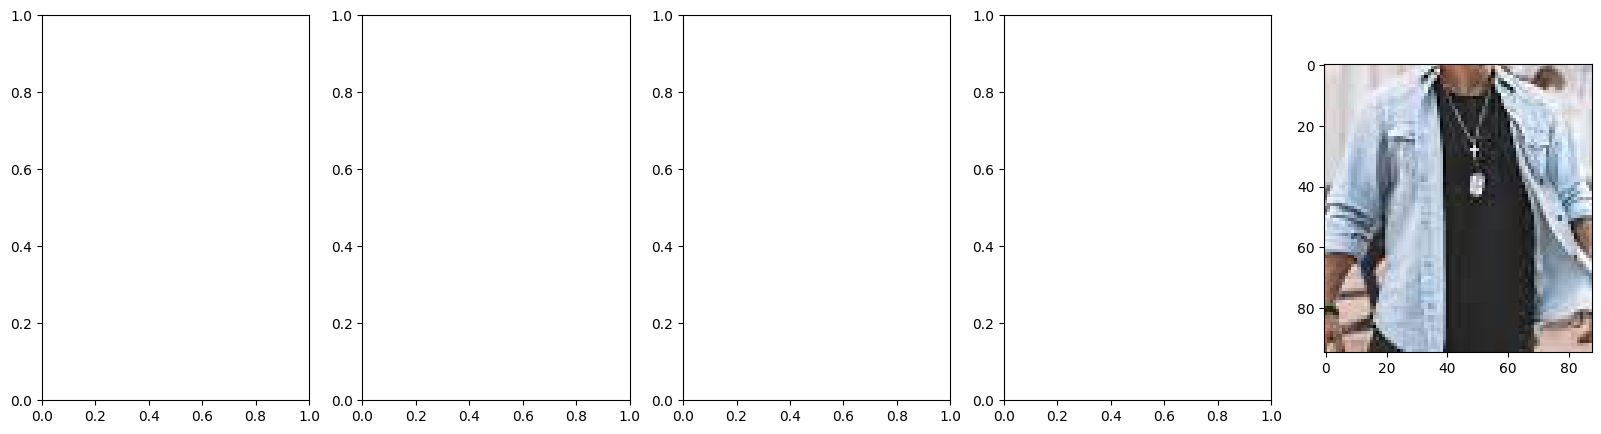

100%|██████████| 17065/17065 [00:07<00:00, 2162.51it/s]


outer


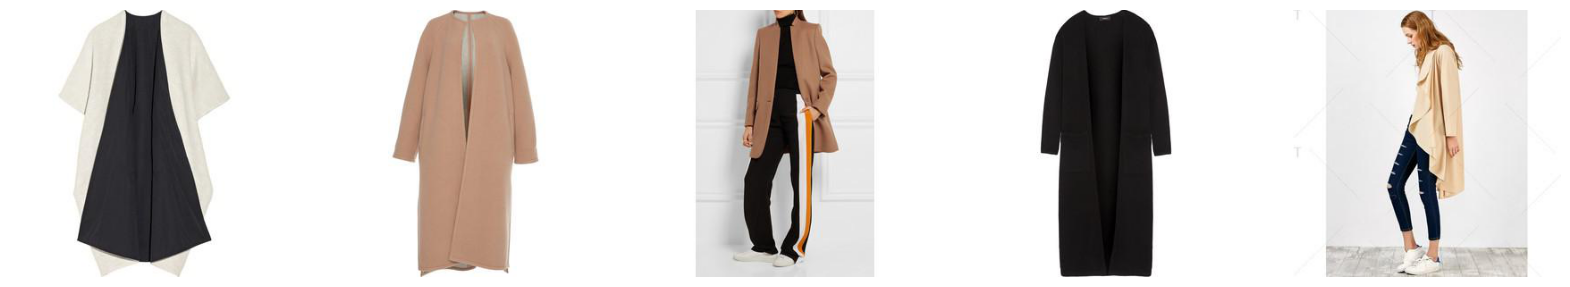

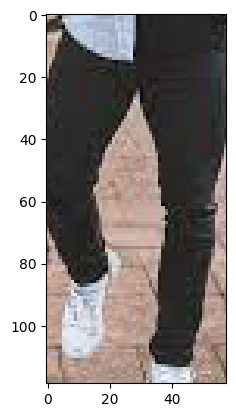

100%|██████████| 27670/27670 [00:12<00:00, 2260.37it/s]


pants


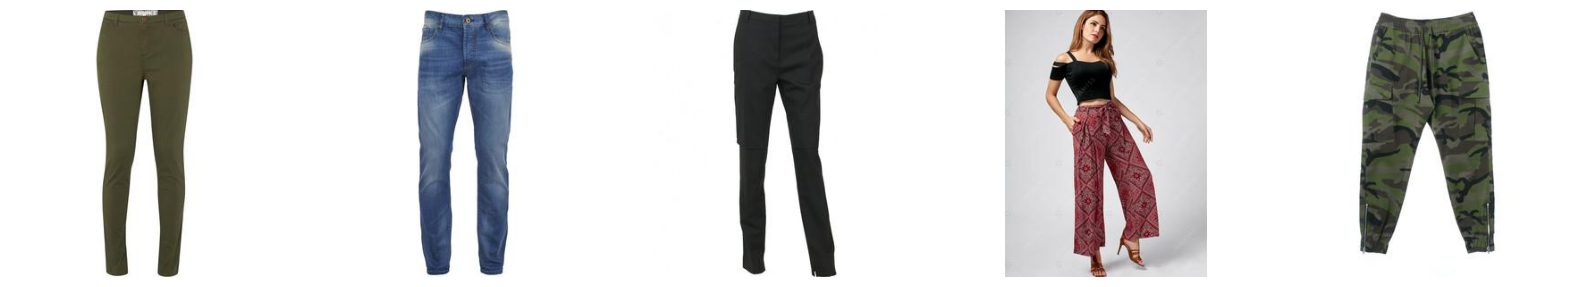

In [23]:
im = np.array(Image.open(img_path))
for x1, y1, x2, y2, conf, cls_pred in details[0]:
    pred_class = classes[int(cls_pred)]
    if pred_class in ("outer", "dress", "pants", "top", "shorts", "skirt"):
        bbox = [int(x1), int(y1), int(x2), int(y2)]
        plt.imshow(im[int(y1):int(y2), int(x1):int(x2), :])
        plt.show()
        A = im[int(y1):int(y2), int(x1):int(x2), :]
        similar_prods = get_similar_products_from_array(image_arr=A, categories=[modanet2polyvore[pred_class]])
        print(pred_class)
        plot_similar_images(similar_prods)
        # im2 = Image.fromarray(A)
        # im2.save("your_file.jpeg")
        

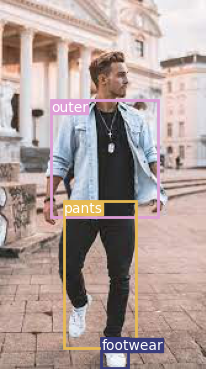

In [31]:
Image.open(opaths[0])

(300, 168, 3)


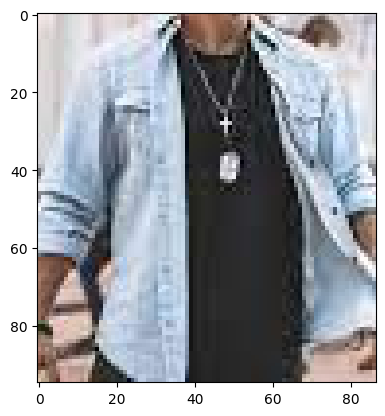

In [52]:
im = np.array(Image.open(img_path))
print(im.shape)
# plt.imshow(im[274:298, 82:103, :])
plt.imshow(im[81:176, 41:128, :])
plt.show()

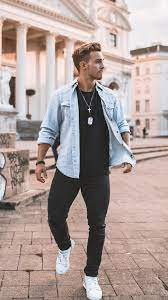

In [49]:
Image.open(img_path)

In [19]:
# use temp_dir, and when done:
temp_dir.cleanup()
output_path.cleanup()